# Assignment 3_1: TDNN and RNN Networks

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.utils.data as data
import torch.nn.functional as F
import torch.optim as optim

from models import *
from learning import *
from utility import *

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
narma_df = pd.read_csv('../NARMA10.csv', header=None)
narma_df.iloc[:, :20] # visualize the first 20 columns

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.083964,0.48934,0.35635,0.25024,0.23554,0.029809,0.34099,0.021216,0.035723,0.26082,0.048365,0.40907,0.40877,0.36122,0.074933,0.32980,0.25930,0.48649,0.32450,0.40017
1,0.000000,0.00000,0.00000,0.00000,0.00000,0.000000,0.00000,0.000000,0.000000,0.00000,0.132850,0.17536,0.37127,0.36481,0.337070,0.20447,0.33003,0.20726,0.18825,0.28343


In [5]:
x_data = torch.tensor(narma_df.iloc[0].values, dtype=torch.float32) # float 32 for better memory efficiency
y_data = torch.tensor(narma_df.iloc[1].values, dtype=torch.float32)

# 4000 tr, 1000 val, 5000 test (WARNING: load entire dataset in memory ONLY because it is small and also the NN is quite small)
dev_x, dev_y = x_data[:5000].to(device), y_data[:5000].to(device) # only used for retraining (train + val sets)

test_x, test_y = x_data[5000:].to(device), y_data[5000:].to(device)

train_x, val_x = dev_x[:4000].to(device), dev_x[4000:].to(device)
train_y, val_y = dev_y[:4000].to(device), dev_y[4000:].to(device)

In [4]:
len(train_x), len(val_x), len(test_x)

(4000, 1000, 5000)

## TDNN

In [29]:
hyperparams = {
    'batch_size': [64], 
    'lr':  [0.001, 0.003, 0.005],
    'weight_decay': [0, 1e-6],
    'epochs': [20],
    'window_size': [10, 20, 30],
    'hidden_size': [20, 30, 50],
}

grid_tdnn = GridSearch(hyperparams)

model_selection_history = grid_tdnn.tdnn_grid_search(train_x, train_y, val_x, val_y, verbose=False)
df = pd.DataFrame.from_dict(model_selection_history, orient='index')
df.to_csv('grid_tdnn_search.csv')

In [30]:
df_results = pd.read_csv('grid_tdnn_search.csv', index_col=0)
df_results.sort_values(by='val_mse', ascending=True).head(10)

,batch_size,lr,weight_decay,epochs,window_size,hidden_size,train_mse,val_mse
config_21,64,0.003,0.000000,20,20,20,0.000178,0.000410
config_39,64,0.005,0.000000,20,20,20,0.000124,0.000442
config_14,64,0.001,0.000001,20,20,50,0.000193,0.000481
config_22,64,0.003,0.000000,20,20,30,0.000114,0.000499
config_30,64,0.003,0.000001,20,20,20,0.000248,0.000560
config_26,64,0.003,0.000000,20,30,50,0.000188,0.000628
config_4,64,0.001,0.000000,20,20,30,0.000473,0.000656
config_34,64,0.003,0.000001,20,30,30,0.000168,0.000661
config_50,64,0.005,0.000001,20,20,50,0.000050,0.000679
config_17,64,0.001,0.000001,20,30,50,0.000241,0.000683


In [32]:
window_size = 20
batch_size = 64
lr = 0.003
weight_decay = 0
epochs = 20
hidden_size = 20

tdnn = TDNN(window_size=window_size, hidden_size=hidden_size, output_size=1).to(device)

train_dataset = TDNNDataset(train_x, train_y, window_size=window_size)
val_dataset = TDNNDataset(val_x, val_y, window_size=window_size)

train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = data.DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)

t_h, val_h = train_tdnn(tdnn, train_loader=train_loader, val_loader=val_loader, lr=lr, weight_decay=weight_decay, epochs=epochs, verbose=True)

Epoch 0 - Train MSE: 0.007423715433105826 - Val MSE: 0.0038226668257266283
Epoch 1 - Train MSE: 0.0020650053407908196 - Val MSE: 0.0013187676668167114
Epoch 2 - Train MSE: 0.0009931949205652234 - Val MSE: 0.0011422991519793868
Epoch 3 - Train MSE: 0.0006893186221113576 - Val MSE: 0.0008069190662354231
Epoch 4 - Train MSE: 0.00046905166227444417 - Val MSE: 0.0007454190053977072
Epoch 5 - Train MSE: 0.0004094061259243135 - Val MSE: 0.0007303716847673059
Epoch 6 - Train MSE: 0.0003885627425800536 - Val MSE: 0.0007141915848478675
Epoch 7 - Train MSE: 0.0003739008557565126 - Val MSE: 0.0007014915463514626
Epoch 8 - Train MSE: 0.0003573877943886651 - Val MSE: 0.0006883507594466209
Epoch 9 - Train MSE: 0.0003403484990398976 - Val MSE: 0.0006730433087795973
Epoch 10 - Train MSE: 0.00032089602355549613 - Val MSE: 0.0006497512804344296
Epoch 11 - Train MSE: 0.0002967829112469825 - Val MSE: 0.0006242622039280832
Epoch 12 - Train MSE: 0.0002700009123174592 - Val MSE: 0.0005957447574473917
Epoch 13

### WARNING: From the plot may seems overfitting but looking at the values(above), both training mse and validation mse decrease at each epoch

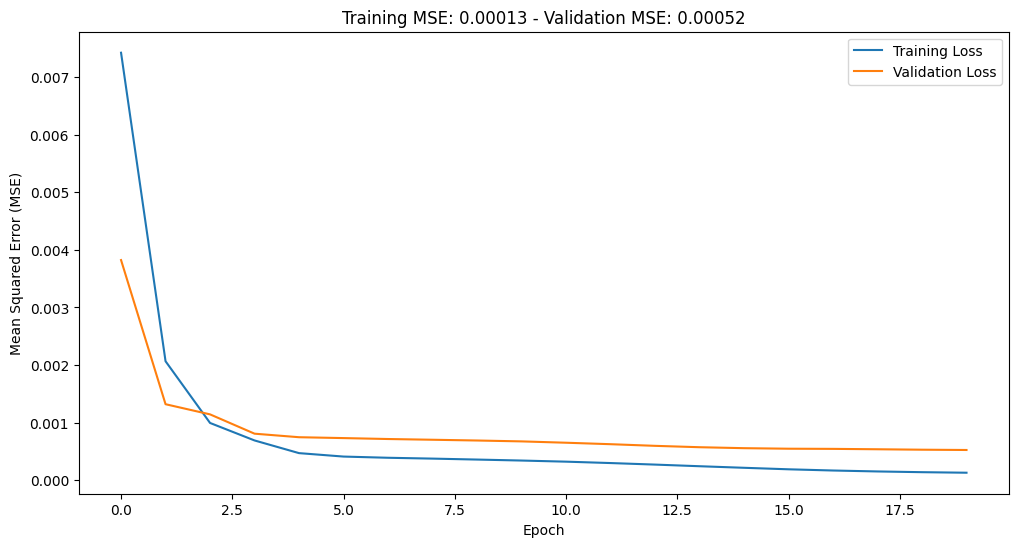

In [43]:
plot_loss(t_h, val_h)

### Retrain TDNN

In [ ]:
window_size = 20
batch_size = 64
lr = 0.003
weight_decay = 0
epochs = 20
hidden_size = 20

final_tdnn = TDNN(window_size=window_size, hidden_size=hidden_size, output_size=1).to(device)

retrain_dataset = TDNNDataset(dev_x, dev_y, window_size=window_size)
retrain_loader = data.DataLoader(retrain_dataset, batch_size=batch_size, shuffle=False)

test_dataset = TDNNDataset(test_x, test_y, window_size=window_size)
test_loader = data.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

retrain_h, test_h = train_tdnn(final_tdnn, train_loader, val_loader, lr=lr, weight_decay=weight_decay, epochs=epochs, verbose=False)

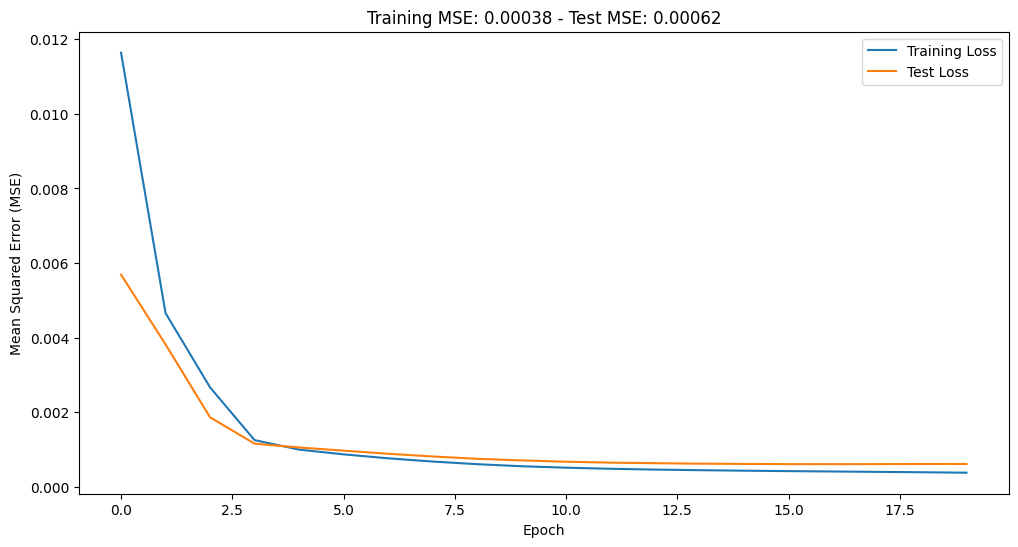

In [44]:
plot_loss(retrain_h, test_h, test=True)

### Training(+Validation) set Reconstruction

In [2]:
window_size = 20
batch_size = 64
lr = 0.003
weight_decay = 0
epochs = 20
hidden_size = 20

final_tdnn = TDNN(window_size=window_size, hidden_size=hidden_size, output_size=1).to(device)
final_tdnn.load_state_dict(torch.load('tdnn_narma10.pt'))

<All keys matched successfully>

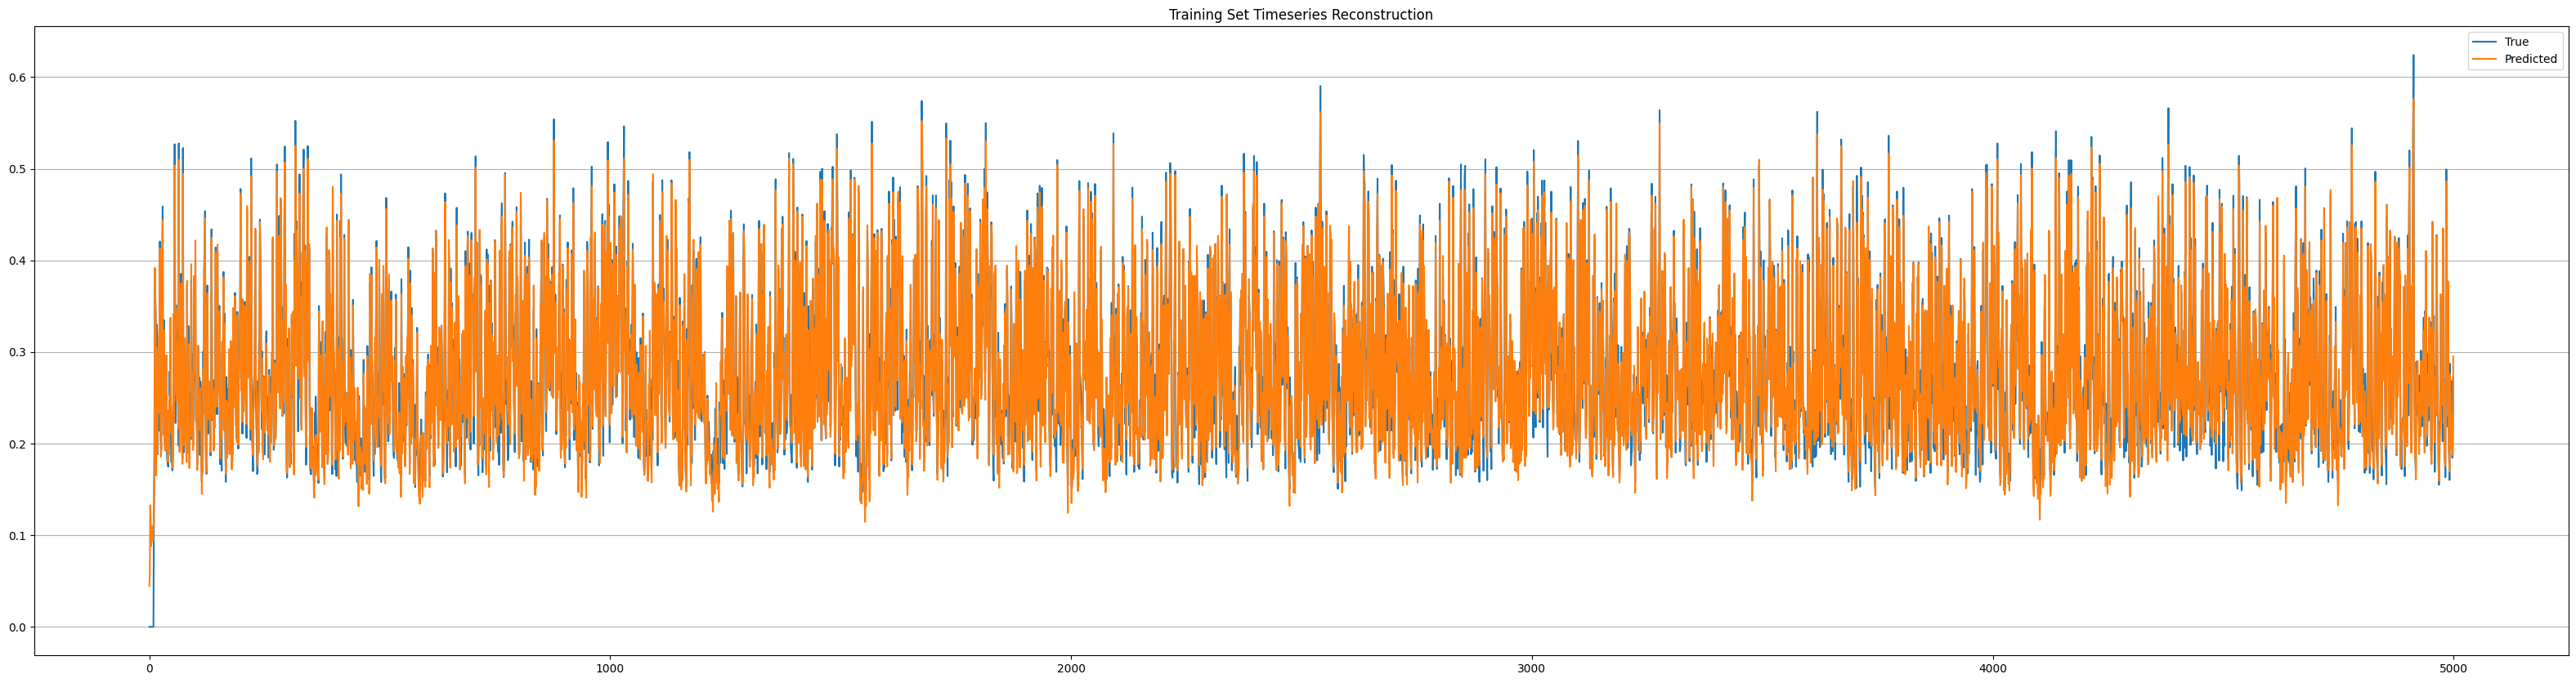

In [6]:
plt.figure(figsize=(40, 10))
plt.grid(True, axis='y')
plt.title('Training Set Timeseries Reconstruction') 

retrain_dataset = TDNNDataset(dev_x, dev_y, window_size=window_size)
retrain_loader = data.DataLoader(retrain_dataset, batch_size=batch_size, shuffle=False)

retrain_loader = data.DataLoader(retrain_dataset, batch_size=len(retrain_dataset), shuffle=False)
for x, y in retrain_loader:
    with torch.no_grad():
        out = final_tdnn(x)
        plt.plot(y.cpu().numpy(), label='True')
        plt.plot(out.cpu().numpy(), label='Predicted')
        plt.legend()
        plt.show()

### Test Set Reconstruction

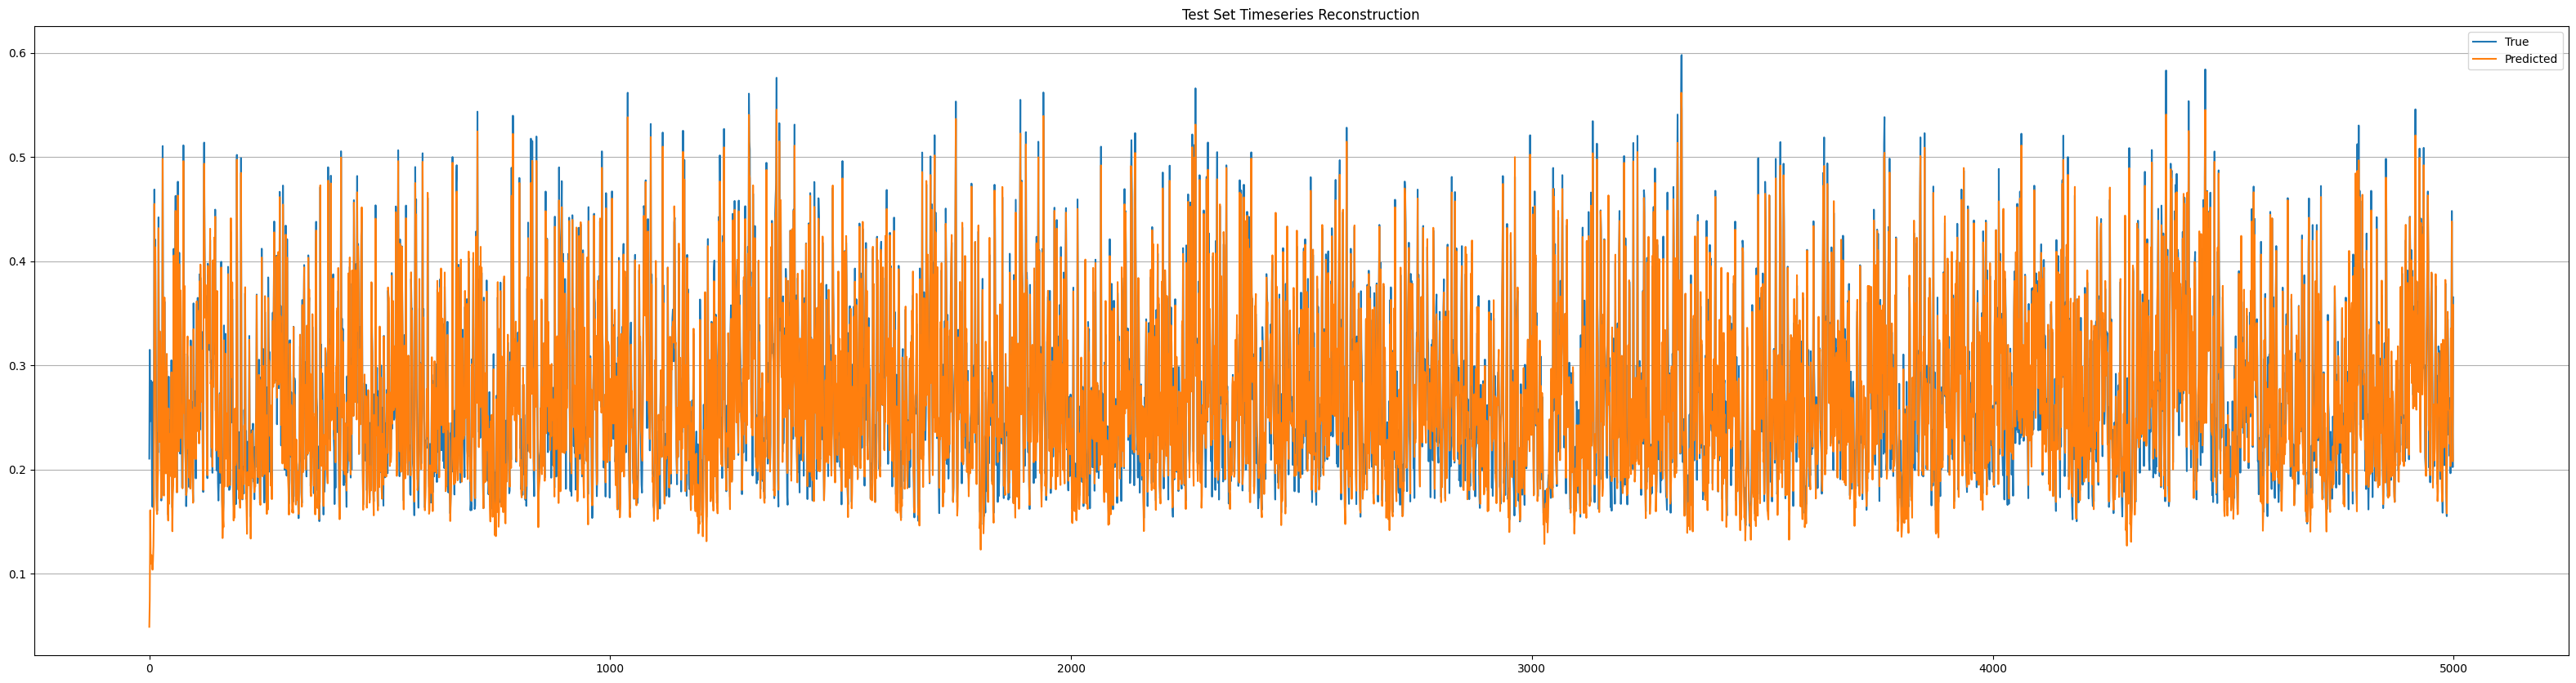

In [8]:
plt.figure(figsize=(40, 10))
plt.grid(True, axis='y')
plt.title('Test Set Timeseries Reconstruction')

test_dataset = TDNNDataset(test_x, test_y, window_size=window_size)
test_loader = data.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

for x, y in test_loader:
    with torch.no_grad():
        out = final_tdnn(x)
        plt.plot(y.cpu().numpy(), label='True')
        plt.plot(out.cpu().numpy(), label='Predicted')
        plt.legend()
        plt.show()

In [38]:
torch.save(final_tdnn.state_dict(), 'tdnn_narma10.pt')

## RNN

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.utils.data as data
import torch.nn.functional as F
import torch.optim as optim

from models import *
from learning import *
from utility import *

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [2]:
narma_df = pd.read_csv('../NARMA10.csv', header=None)
narma_df.iloc[:, :20] # visualize the first 20 columns

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.083964,0.48934,0.35635,0.25024,0.23554,0.029809,0.34099,0.021216,0.035723,0.26082,0.048365,0.40907,0.40877,0.36122,0.074933,0.32980,0.25930,0.48649,0.32450,0.40017
1,0.000000,0.00000,0.00000,0.00000,0.00000,0.000000,0.00000,0.000000,0.000000,0.00000,0.132850,0.17536,0.37127,0.36481,0.337070,0.20447,0.33003,0.20726,0.18825,0.28343


In [3]:
x_data = torch.tensor(narma_df.iloc[0].values, dtype=torch.float32) # float 32 for better memory efficiency
y_data = torch.tensor(narma_df.iloc[1].values, dtype=torch.float32)

# 4000 tr, 1000 val, 5000 test (WARNING: load entire dataset in memory ONLY because it is small and also the NN is quite small)
dev_x, dev_y = x_data[:5000].to(device), y_data[:5000].to(device) # only used for retraining (train + val sets)

test_x, test_y = x_data[5000:].to(device), y_data[5000:].to(device)

train_x, val_x = dev_x[:4000].to(device), dev_x[4000:].to(device)
train_y, val_y = dev_y[:4000].to(device), dev_y[4000:].to(device)

In [4]:
len(train_x), len(val_x), len(test_x)

(4000, 1000, 5000)

In [84]:
rnn = VanillaRNN(input_size=1, hidden_size=20, output_size=1).to(device)

train_dataset = RNNDataset(train_x, train_y)
val_dataset = RNNDataset(val_x, val_y)

train_loader = data.DataLoader(train_dataset, batch_size=1000, shuffle=False)
val_loader = data.DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)

In [85]:
t_h, v_h = train_rnn(rnn, train_loader, val_loader, lr=0.001, weight_decay=1e-5, epochs=20, clip_trheshold=0, verbose=True)

Epoch 0 - Train MSE: 0.3237866088747978 - Val MSE: 0.26275014877319336
Epoch 1 - Train MSE: 0.233660738915205 - Val MSE: 0.184594064950943
Epoch 2 - Train MSE: 0.1615021713078022 - Val MSE: 0.12267906218767166
Epoch 3 - Train MSE: 0.104647321626544 - Val MSE: 0.07481022924184799
Epoch 4 - Train MSE: 0.061457606963813305 - Val MSE: 0.040112994611263275
Epoch 5 - Train MSE: 0.031298388727009296 - Val MSE: 0.018217911943793297
Epoch 6 - Train MSE: 0.013785058399662375 - Val MSE: 0.00845223106443882
Epoch 7 - Train MSE: 0.007654515560716391 - Val MSE: 0.008070374839007854
Epoch 8 - Train MSE: 0.008948021568357944 - Val MSE: 0.011146938428282738
Epoch 9 - Train MSE: 0.011463248170912266 - Val MSE: 0.012174471281468868
Epoch 10 - Train MSE: 0.011396468617022038 - Val MSE: 0.010531555861234665
Epoch 11 - Train MSE: 0.009511940879747272 - Val MSE: 0.00847874116152525
Epoch 12 - Train MSE: 0.007885693106800318 - Val MSE: 0.007421121001243591
Epoch 13 - Train MSE: 0.007282758946530521 - Val MSE:

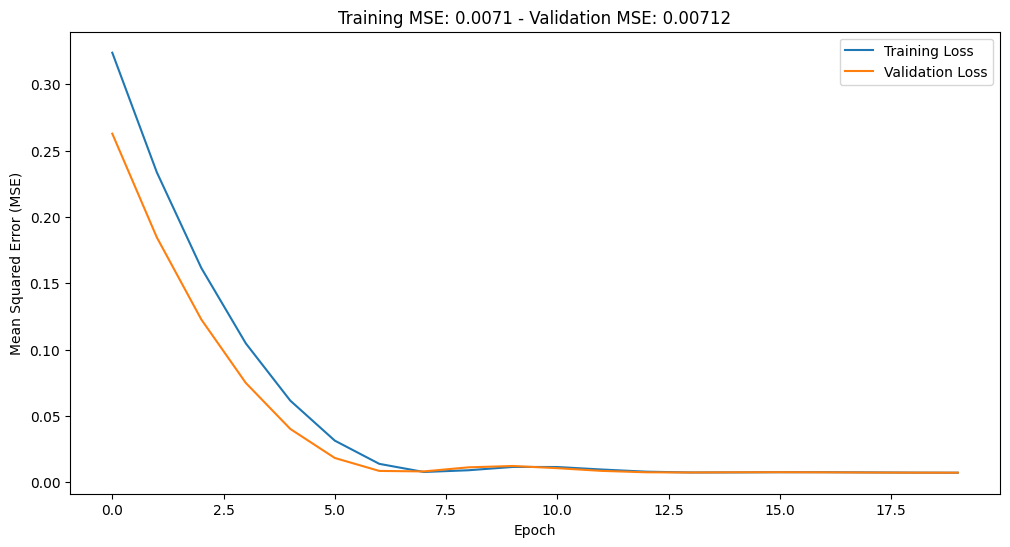

In [86]:
plot_loss(t_h, v_h)

In [87]:
rnn = nn.RNN(10, 20, 2)
input = torch.randn(5, 3, 10)
output, hn = rnn(input, None)
input.shape, output.shape, hn.shape

(torch.Size([5, 3, 10]), torch.Size([5, 3, 20]), torch.Size([2, 3, 20]))